Looking at College Football (CFB) data through week 12, with an emphasis on Michigan data.
Looking at run/pass distribution, and play calling.

Did not check data for normalcy -- was quick though experiment/ eda to find interesting data

In [3]:
# Import statements

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Have play by play data for each week.
# Want to initalize each week seperately

allgames = pd.DataFrame()

# grab each week, through into dataframe
for i in range(1,13):
    week = i
    filename = str('csv_week' + str(week))
    filepath = str('./drive-download-20171111T203157Z-001/PBP - 2017 - Week ' + str(week) + '.csv')
    dataframe = pd.read_csv(filepath)
    
    # Need to adjust certain weeks because data was inverted (yard lines)
    if i == 1 or i == 11 or i ==7:
        dataframe['adjustedyardLine'] = 100 - dataframe.yardLine.values
        dataframe['adjustedendYardLine'] = 100 - dataframe.endYardLine.values
        del dataframe['yardLine']
        del dataframe['endYardLine']
        dataframe.rename(columns={'adjustedyardLine': 'yardLine'}, inplace=True)
        dataframe.rename(columns={'adjustedendYardLine': 'endYardLine'}, inplace=True)
    
    # Concatenate week data to allgames df
    allgames = pd.concat((allgames,dataframe), axis=0)

In [5]:
# Take off special teams play (non punting), and split into rushing or passing plays

alldowns = allgames[allgames.down != 0]
alldowns = alldowns[alldowns.type != 'Kickoff']
alldowns = alldowns.dropna()
allpassing = alldowns[alldowns.type.str.contains('Pass|Sack|Intercep')]
allrushing = alldowns[alldowns.type.str.contains('Rush')]

In [6]:
# Seperate data for michigan

allmichigandefense = alldowns[alldowns.defenseAbbr == 'MICH']
allmichiganpassdefense = allmichigandefense[allmichigandefense.type.str.contains('Pass|Sack|Intercep')]
allmichiganrushdefense = allmichigandefense[allmichigandefense.type.str.contains('Rush')]

In [7]:
# Continue seperating data for michigan

allmichigan = allgames[allgames.offenseAbbr == 'MICH']
allmichiganoffense = allmichigan[allmichigan.offenseAbbr == 'MICH']
allmichiganoffense = allmichiganoffense[allmichiganoffense.down != 0]
allmichiganoffense = allmichiganoffense[allmichiganoffense.type != 'Kickoff']
allmichiganscoring = allmichiganoffense[allmichiganoffense.isScoringPlay == True]
michigantds = allmichiganscoring[allmichiganscoring.type.str.contains('Touchdown')]

In [8]:
# Continue seperating data for michigan

allmichiganpassing = allmichiganoffense[allmichiganoffense.type.str.contains('Pass|Sack|Intercep')]
allmichiganrushing = allmichiganoffense[allmichiganoffense.type.str.contains('Rush')]

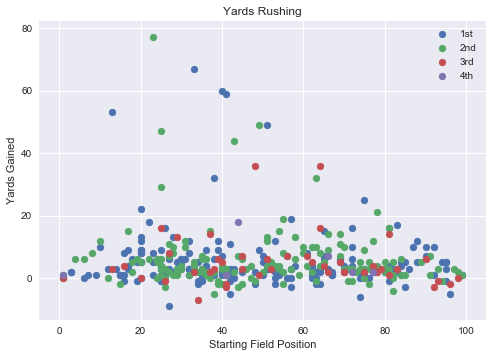

In [9]:
# Cursory look: split all data into start position and outcome, color by down

downs = [1,2,3,4]
for i in downs:
    df = allmichiganrushing[allmichiganrushing.down == i]
    plt.scatter(df.yardLine, df.yardsGained)
plt.xlabel('Starting Field Position')
plt.ylabel('Yards Gained')
plt.legend(['1st', '2nd', '3rd', '4th'])
plt.title('Yards Rushing')
plt.show()

#  diagonal upper bound max yards/position. Big plays primarilly on 1st/2nd down, but higher volume

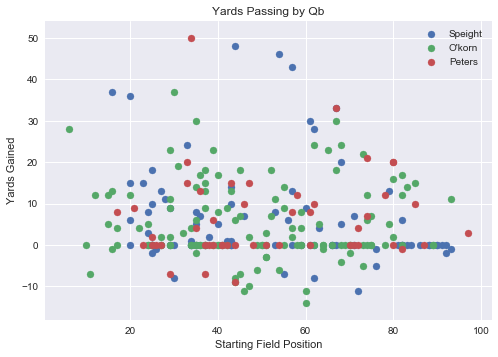

In [70]:
# There have been three different QBs playing this year. Checking to see if there is noticeable difference

qbs = ['Speight', "O'Korn", 'Peters']
for i in qbs:
    df = allmichiganpassing
    df = df[df.description.str.contains(i)]
    plt.scatter(df.yardLine, df.yardsGained)
plt.xlabel('Starting Field Position')
plt.ylabel('Yards Gained')
plt.legend(['Speight', "O'korn", "Peters"])
plt.title("Yards Passing by Qb")
plt.show()

In [71]:
# Appears that Speight has more explosive plays, Okorn has more negative plays

In [72]:
# Breakdown of playcall split by down

# initalize dict (with keys being downs 1-4)
downdict = {}
downdict[1] = {}
downdict[2] = {}
downdict[3] = {}
downdict[4] = {}

# Split pass outcomes by down
for i in range(len(allmichiganpassing)):
    row = allmichiganoffense[['down', 'type']].iloc[i]
    down = row.down
    playtype = row.type
    
    # add to dict
    if playtype in downdict[down]:
        downdict[down][playtype] += 1
    else:
        downdict[down][playtype] = 1

# Split rush outcomes my down        
for i in range(len(allmichiganrushing)):
    row = allmichiganoffense[['down', 'type']].iloc[i]
    down = row.down
    playtype = row.type
    
    # add to dict
    if playtype in downdict[down]:
        downdict[down][playtype] += 1
    else:
        downdict[down][playtype] = 1

In [73]:
# Lets see how it looks

downdict

{1: {'Fumble Recovery (Opponent)': 5,
  'Fumble Recovery (Own)': 2,
  'Pass Incompletion': 31,
  'Pass Reception': 35,
  'Passing Touchdown': 4,
  'Penalty': 6,
  'Rush': 143,
  'Rushing Touchdown': 1,
  'Sack': 7,
  'Timeout': 2},
 2: {'Fumble Recovery (Opponent)': 1,
  'Fumble Recovery (Own)': 2,
  'Pass Incompletion': 20,
  'Pass Reception': 45,
  'Passing Touchdown': 2,
  'Penalty': 12,
  'Rush': 96,
  'Rushing Touchdown': 4,
  'Sack': 7,
  'Timeout': 10},
 3: {'Interception Return Touchdown': 4,
  'Pass Incompletion': 35,
  'Pass Interception Return': 1,
  'Pass Reception': 26,
  'Passing Touchdown': 1,
  'Penalty': 2,
  'Rush': 44,
  'Rushing Touchdown': 2,
  'Sack': 7,
  'Timeout': 10},
 4: {'Blocked Punt': 2,
  'Field Goal Good': 23,
  'Field Goal Missed': 4,
  'Pass Reception': 3,
  'Penalty': 6,
  'Punt': 36,
  'Rush': 5,
  'Timeout': 8}}

In [74]:
# Turning it into percentages for each play

off_dict_pct = {}

for num,key in enumerate(downdict.keys()):
    off_dict_pct[num + 1] = {}
    down = off_dict_pct[num + 1]
    group = downdict[key]
    plays = sum(group.values())
    for key in group.keys():
        play_type = key
        percentages = "{0} %".format(round(group[play_type]/plays * 100,1))
        down[play_type] = percentages

In [75]:
# Examining

off_dict_pct

{1: {'Fumble Recovery (Opponent)': '2.1 %',
  'Fumble Recovery (Own)': '0.8 %',
  'Pass Incompletion': '13.1 %',
  'Pass Reception': '14.8 %',
  'Passing Touchdown': '1.7 %',
  'Penalty': '2.5 %',
  'Rush': '60.6 %',
  'Rushing Touchdown': '0.4 %',
  'Sack': '3.0 %',
  'Timeout': '0.8 %'},
 2: {'Fumble Recovery (Opponent)': '0.5 %',
  'Fumble Recovery (Own)': '1.0 %',
  'Pass Incompletion': '10.1 %',
  'Pass Reception': '22.6 %',
  'Passing Touchdown': '1.0 %',
  'Penalty': '6.0 %',
  'Rush': '48.2 %',
  'Rushing Touchdown': '2.0 %',
  'Sack': '3.5 %',
  'Timeout': '5.0 %'},
 3: {'Interception Return Touchdown': '3.0 %',
  'Pass Incompletion': '26.5 %',
  'Pass Interception Return': '0.8 %',
  'Pass Reception': '19.7 %',
  'Passing Touchdown': '0.8 %',
  'Penalty': '1.5 %',
  'Rush': '33.3 %',
  'Rushing Touchdown': '1.5 %',
  'Sack': '5.3 %',
  'Timeout': '7.6 %'},
 4: {'Blocked Punt': '2.3 %',
  'Field Goal Good': '26.4 %',
  'Field Goal Missed': '4.6 %',
  'Pass Reception': '3.4 %',

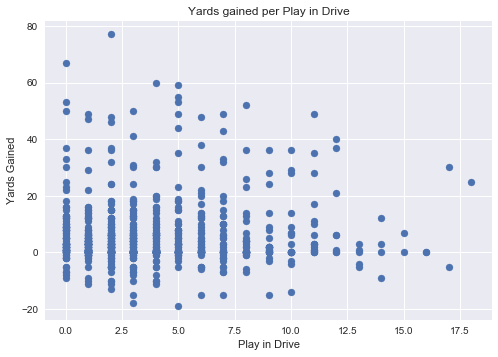

In [76]:
# Looking at drive sequences

_ = plt.scatter(allmichiganoffense.playIndex, allmichiganoffense.yardsGained)
_ = plt.xlabel('Play in Drive')
_ = plt.ylabel('Yards Gained')
_ = plt.title('Yards gained per Play in Drive')
plt.show()

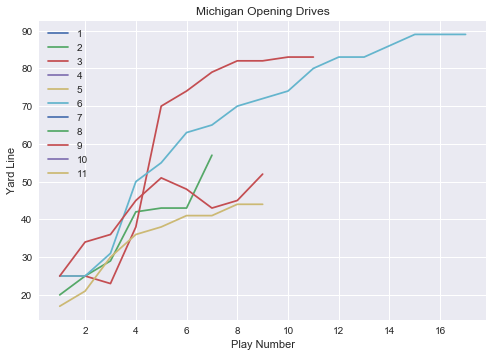

In [77]:
# We can also plot out how Opening (or nth) drive of game goes (only when M recieves kickoff)

weeks = range(1,12)

# grab/plot 1st drive for each week
for i in weeks:
    df = allmichiganoffense[allmichiganoffense.driveIndex == 0]
    df = df[df.week == i]
    plt.plot(df.playIndex, df.yardLine)

# Label axises    
_ = plt.legend(weeks)
_ = plt.xlabel('Play Number')
_ = plt.ylabel('Yard Line')
_ = plt.title('Michigan Opening Drives')
plt.show()

In [78]:
# One last look at offense before switching over to defense

allmichiganoffense.head().T

,6135,6136,6137,6138,6139
awayAbbr,MICH,MICH,MICH,MICH,MICH
awayId,130,130,130,130,130
awayScore,0,0,0,0,0
awayTeam,Michigan,Michigan,Michigan,Michigan,Michigan
clock,12:26,11:39,11:08,10:34,10:01
defenseAbbr,FLA,FLA,FLA,FLA,FLA
defenseId,57,57,57,57,57
defenseTeam,Florida,Florida,Florida,Florida,Florida
description,Chris Evans run for a loss of 1 yard to the Mi...,Wilton Speight pass complete to Kekoa Crawford...,Wilton Speight run for 8 yds to the Mich 35 fo...,Khalid Hill run for 1 yd to the Mich 36,"Speight, Wilton pass incomplete to Crawford, K..."
distance,10,11,8,10,9


In [79]:
# Same as above, seeing how other teams gameplan michigan defense

defdowndict = {}
defdowndict[1] = {}
defdowndict[2] = {}
defdowndict[3] = {}
defdowndict[4] = {}

# Playcalls/pass
for i in range(len(allmichiganpassdefense)):
    row = allmichiganpassdefense[['down', 'type']].iloc[i]
    down = row.down
    playtype = row.type
    if playtype in defdowndict[down]:
        defdowndict[down][playtype] += 1
    else:
        defdowndict[down][playtype] = 1

# playcalls/rush        
for i in range(len(allmichiganrushdefense)):
    row = allmichiganrushdefense[['down', 'type']].iloc[i]
    down = row.down
    playtype = row.type
    if playtype in defdowndict[down]:
        defdowndict[down][playtype] += 1
    else:
        defdowndict[down][playtype] = 1

In [80]:
# Lets take a look at it
defdowndict

{1: {'Interception Return Touchdown': 1,
  'Pass Incompletion': 51,
  'Pass Reception': 45,
  'Passing Touchdown': 4,
  'Rush': 134,
  'Rushing Touchdown': 6,
  'Sack': 10},
 2: {'Pass Incompletion': 35,
  'Pass Interception Return': 3,
  'Pass Reception': 38,
  'Passing Touchdown': 2,
  'Rush': 105,
  'Rushing Touchdown': 4,
  'Sack': 8},
 3: {'Interception Return Touchdown': 1,
  'Pass Incompletion': 43,
  'Pass Interception Return': 2,
  'Pass Reception': 30,
  'Passing Touchdown': 1,
  'Rush': 43,
  'Rushing Touchdown': 1,
  'Sack': 11},
 4: {'Pass Incompletion': 2,
  'Pass Interception Return': 1,
  'Pass Reception': 3,
  'Rush': 4}}

In [81]:
# Turning it into percent

def_dict_pct = {}

for num,key in enumerate(defdowndict.keys()):
    def_dict_pct[num + 1] = {}
    down = def_dict_pct[num + 1]
    group = defdowndict[key]
    plays = sum(group.values())
    for key in group.keys():
        play_type = key
        percentages = "{0} %".format(round(group[play_type]/plays * 100,1))
        down[play_type] = percentages

In [82]:
# Lets look again

def_dict_pct

{1: {'Interception Return Touchdown': '0.4 %',
  'Pass Incompletion': '20.3 %',
  'Pass Reception': '17.9 %',
  'Passing Touchdown': '1.6 %',
  'Rush': '53.4 %',
  'Rushing Touchdown': '2.4 %',
  'Sack': '4.0 %'},
 2: {'Pass Incompletion': '17.9 %',
  'Pass Interception Return': '1.5 %',
  'Pass Reception': '19.5 %',
  'Passing Touchdown': '1.0 %',
  'Rush': '53.8 %',
  'Rushing Touchdown': '2.1 %',
  'Sack': '4.1 %'},
 3: {'Interception Return Touchdown': '0.8 %',
  'Pass Incompletion': '32.6 %',
  'Pass Interception Return': '1.5 %',
  'Pass Reception': '22.7 %',
  'Passing Touchdown': '0.8 %',
  'Rush': '32.6 %',
  'Rushing Touchdown': '0.8 %',
  'Sack': '8.3 %'},
 4: {'Pass Incompletion': '20.0 %',
  'Pass Interception Return': '10.0 %',
  'Pass Reception': '30.0 %',
  'Rush': '40.0 %'}}

In [83]:
# Seeing all outcomes for rush defense
allmichiganrushdefense.type.unique()

array(['Rush', 'Rushing Touchdown'], dtype=object)

In [84]:
# Creating a category to combine rushing/passing plays
# Use one below

#for i in range(len(allmichigandefense)):
#    if 'Rush' in allmichigandefense.iloc[i].type:
#        allmichigandefense.iloc[i]['Cat'] = 'Rush'
    
    
    #  allmichigandefense['Cat'] = 'Rush'
#if allmichigandefense.type.str.contains('Pass|Sack|Intercep') == True:
 #   allmichigandefense['Cat'] = 'Pass'

In [85]:
# Creating a category to combine rushing/passing plays. putting in list, appending list

# empty List
cat = []

# put rush if rush, put pass if pass play
for i in range(len(allmichigandefense)):
    if 'Rush' in allmichigandefense.iloc[i].type:
        cat.append('Rush')
    elif ('Pass') in allmichigandefense.iloc[i].type:
        cat.append('Pass')
    elif ('Sack') in allmichigandefense.iloc[i].type:
        cat.append('Pass')
    elif 'ntercept' in allmichigandefense.iloc[i].type:
        cat.append('Pass')
    else:
        cat.append('Other')

In [86]:
# Find out what the 'Other' category is

for x,y in list(enumerate(cat)):
    if y == 'Other':
        print(x, allmichigandefense.iloc[x].type, allmichigandefense.iloc[x].description)

2 Fumble Recovery (Own) Feleipe Franks run for a loss of 4 yards to the Mich 26 Feleipe Franks fumbled, recovered by Fla Feleipe Franks
4 Timeout Timeout FLORIDA, clock 12:36
5 Penalty FLORIDA Penalty, False Start (Martez Ivey) to the Mich 32
7 Field Goal Good Eddy Pineiro 46 Yd Field Goal 
11 Punt Johnny Townsend punt for 59 yds , Donovan Peoples-Jones returns for 7 yds to the Mich 25
18 Punt Johnny Townsend punt for 55 yds , Donovan Peoples-Jones returns for 18 yds to the Mich 26
22 Field Goal Missed Eddy Pineiro 47 yd FG MISSED
26 Penalty FLORIDA Penalty, Offensive Holding (-10 Yards) to the Fla 43
28 Punt Johnny Townsend punt for 51 yds , Donovan Peoples-Jones returns for 1 yd to the Mich 7
31 Fumble Recovery (Opponent) Feleipe Franks run for 6 yds to the Fla 37 Feleipe Franks fumbled, forced by Josh Metellus, recovered by Mich Lawrence Marshall
34 Timeout Timeout FLORIDA, clock 07:51
36 Punt Johnny Townsend punt for 53 yds , Donovan Peoples-Jones returns for 6 yds to the Mich 27
4

In [87]:
# Since all others are special teams/penalties, we do not need to look further into it

# append list to df
allmichigandefense['Cat'] = cat

/Users/joelelster/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [88]:
# Now looking to put bins of play length, ang group them

distancebins = []
for i in range(len(allmichigandefense)):
    if allmichigandefense.iloc[i].distance < 3:
        distancebins.append('0-2')
    elif allmichigandefense.iloc[i].distance < 5:
        distancebins.append('2-4')
    elif allmichigandefense.iloc[i].distance < 7:
        distancebins.append('4-6')
    elif allmichigandefense.iloc[i].distance < 9:
        distancebins.append('6-8')
    elif allmichigandefense.iloc[i].distance < 11:
        distancebins.append('8-10')
    elif allmichigandefense.iloc[i].distance < 16:
        distancebins.append('10-15')
    elif allmichigandefense.iloc[i].distance > 15:
        distancebins.append('16+')

In [89]:
# appending it on

allmichigandefense['Distancebin'] = distancebins

/Users/joelelster/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [90]:
# Create defdf of down, distancebin, and cat (filter out other)

defdf = allmichigandefense[allmichigandefense.Cat != 'Other'][['down', 'Distancebin', 'Cat']]

In [92]:
# Making sure we have 4 downs, 7 distance bins, and 2 cats (rush, pass)

defdf.nunique()

down           4
Distancebin    7
Cat            2
dtype: int64

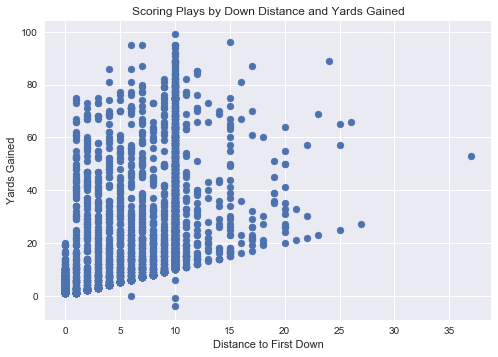

In [94]:
# Plotting all Scoring plays by down distance and yards gained

# Select scoring plays
allscores = allgames[allgames.isScoringPlay == True]

allscores = allscores.dropna()

# Scoring that is rush/pass (non defense/special teams)
allscores = allscores[allscores.type.str.contains('Rush|Pass')]

# Plot and labelling
_ = plt.scatter(x= allscores[['distance']], y=allscores[['yardsGained']])
_ = plt.ylabel('Yards Gained')
_ = plt.xlabel('Distance to First Down')
_ = plt.title('Scoring Plays by Down Distance and Yards Gained')

plt.show()

# Seems like there are 4 data points that are incorrect. 

In [96]:
# Looking at long scoring plays (by down distance)

allscores[allscores.distance > 25]

,awayAbbr,awayId,awayScore,awayTeam,clock,defenseAbbr,defenseId,defenseTeam,description,distance,...,offenseAbbr,offenseId,offenseTeam,playIndex,quarter,type,week,yardLine,yardsGained,year
3442,ULM,2433,0,UL Monroe,10:43,ULM,2433,UL Monroe,"Patrick Taylor Jr. run for 66 yds for a TD, (R...",26,...,MEM,235,Memphis,2,1,Rushing Touchdown,1,66,66,2017
12505,SDSU,21,30,San Diego State,8:34,SDSU,21,San Diego State,Manny Wilkins pass complete to Frank Darby for...,37,...,ASU,9,Arizona State,13,4,Passing Touchdown,2,47,53,2017
5440,STAN,24,7,Stanford,5:29,STAN,24,Stanford,Luke Falk pass complete to Renard Bell for 27 ...,27,...,WSU,265,Washington St,7,2,Passing Touchdown,10,73,27,2017


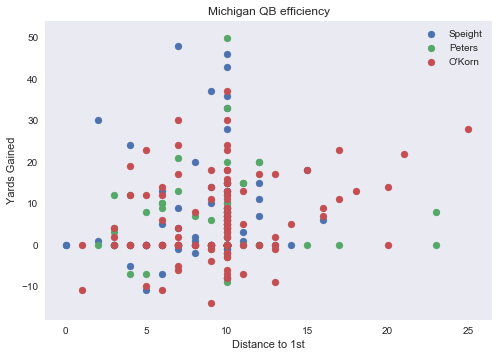

In [33]:
# Now looking at Michigan Quarterbacks

qbs = ['Speight', 'Peters', "O'Korn"]

for qb in qbs:
    df = allmichiganpassing[allmichiganpassing.description.str.contains(qb)]
    plt.scatter(df.distance, df.yardsGained)

# Labelling
_ = plt.xlabel('Distance to 1st')
_ = plt.ylabel('Yards Gained')
_ = plt.legend(qbs)
_ = plt.grid(which='both')
_ = plt.title('Michigan QB efficiency')
plt.show()

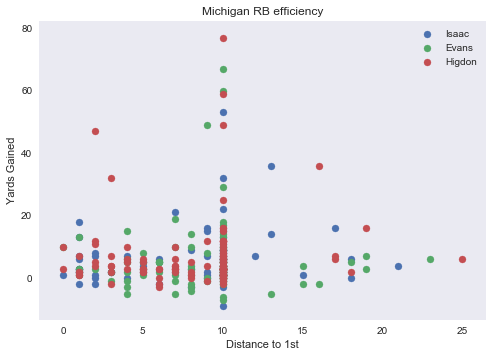

In [97]:
# Now on to RBs

rbs = ['Isaac', 'Evans', 'Higdon']

for rb in rbs:
    df = allmichiganrushing[allmichiganrushing.description.str.contains(rb)]
    plt.scatter(df.distance, df.yardsGained)

_ = plt.xlabel('Distance to 1st')
_ = plt.ylabel('Yards Gained')
_ = plt.legend(rbs)
_ = plt.grid(which='both')
_ = plt.title('Michigan RB efficiency')
plt.show()

# Final Thoughts

Analysis was interesting but very cursory. If more in depth analyis were done would be interesting to look at:

- Distribution of scores/distances/yards gained/play to check for normality
- If distribution is normal, check if there is any difference between qbs/rbs/wrs

- Looking at yards gained past the first down marker
- Look at total scores/outcomes to see if scores can be predicted based off yards/rush or yards/pass